In [3]:
# !pip install virtualenv --user

In [4]:
# !python3 -m venv demo-env

In [5]:
# !demo-env\Scripts\activate.bat

In [6]:
# !pip search sklearn

In [7]:
# !pip install scikit-learn --user

In [187]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys

In [105]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
#Import Feature Selection tools
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression

from random import random, randint
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split  

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import (SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC,
                                    KMeansSMOTE)

In [350]:
from warnings import simplefilter,filterwarnings
from sklearn.exceptions import DataConversionWarning
simplefilter(action='ignore',category = FutureWarning)
simplefilter(action='ignore',category = RuntimeWarning)
filterwarnings(action='ignore',category=DataConversionWarning)
import pandas as pd
pd.options.mode.chained_assignment = None 

In [182]:
raw_data = pd.read_csv("corn_data.csv")
raw_data.head(20)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1126,1127,1128,1129,1130,1131,1132,1133,1134,output
0,0,1,-1,1,1,1,0,1,-1,1,...,-1,1,-1,1,1,-1,0,0,-1,2.516485
1,1,1,-1,1,1,-1,-1,1,-1,1,...,-1,1,-1,0,1,-1,-1,1,0,1.640909
2,2,0,1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,1,1,-1,-1,1,0,0.416348
3,3,1,1,1,0,-1,1,1,-1,1,...,-1,1,-1,-1,1,-1,-1,1,0,1.338558
4,4,1,1,1,0,-1,-1,1,0,1,...,-1,1,-1,0,-1,-1,1,1,0,1.729517
5,5,1,-1,1,1,-1,-1,1,-1,1,...,0,1,-1,-1,-1,-1,-1,1,0,2.704476
6,6,1,1,1,1,-1,-1,1,-1,1,...,-1,1,-1,-1,-1,1,-1,1,0,1.971622
7,7,1,1,1,0,-1,-1,1,1,1,...,-1,1,0,0,-1,-1,-1,1,0,1.843582
8,8,1,1,0,0,0,-1,1,0,1,...,-1,1,-1,0,0,-1,-1,1,1,2.082107
9,9,1,1,1,1,0,-1,1,0,1,...,-1,1,-1,0,1,-1,-1,1,0,2.898305


In [377]:
X = raw_data.iloc[:,1:-1]
y = raw_data.iloc[:,-1:]

#### Testing for KNeighbors

In [375]:
from sklearn.neighbors import NearestNeighbors

In [506]:
# n_neighbors = 7
# neigh = NearestNeighbors(n_neighbors = n_neighbors)
# neigh.fit(X)
# A = neigh.kneighbors(X,n_neighbors)
# y_neigh = np.array([[y.loc[ele,:] for ele in arr] for arr in A[1]])
# y_neigh = np.reshape(y_neigh,(len(y),n_neighbors))
# y_neigh_mean = np.mean(y_neigh, axis =1)
# a = np.where(y_neigh_mean >= 3)
# [y.iloc[i,:] for i in a]
# [y.iloc[i] for i in np.where(np.array(y)>= 3)]

#### Using discretizer

In [627]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import KBinsDiscretizer
from sklearn import preprocessing

In [505]:
X1 = [1,1.1,1.2,1.2,1.99,2,2.3,2.5,2.9,3.9,4.0,4.1,4.6,4.7,4.9,4.99,4.999,10]
X1 = np.reshape(sorted(X1),(len(X1),1))*-1
est1 = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
est2 = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
est3 = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

est1.fit(X1)
est2.fit(X1)
est3.fit(X1)

Xt1 = est1.transform(X1)
Xt2 = est2.transform(X1)
Xt3 = est3.transform(X1)

df_ = pd.DataFrame(columns=["org","kmeans","uniform","quantile"])
print(est.bin_edges_)
[(a,b,c,d) for (a,b,c,d) in zip(X1,Xt1,Xt2,Xt3) ]# doctest: +SKIP
for (a,b,c,d) in zip(X1,Xt1,Xt2,Xt3):
    df_ = df_.append(pd.Series((a,b,c,d),index=["org","kmeans","uniform","quantile"],name="series"))
df_

[array([-4.999 , -4.4189, -3.2125, -1.775 , -1.    ])]


,org,kmeans,uniform,quantile
series,[-1.0],[4.0],[4.0],[4.0]
series,[-1.1],[4.0],[4.0],[4.0]
series,[-1.2],[4.0],[4.0],[4.0]
series,[-1.2],[4.0],[4.0],[4.0]
series,[-1.99],[3.0],[4.0],[3.0]
series,[-2.0],[3.0],[4.0],[3.0]
series,[-2.3],[3.0],[4.0],[3.0]
series,[-2.5],[3.0],[4.0],[2.0]
series,[-2.9],[3.0],[3.0],[2.0]
series,[-3.9],[2.0],[3.0],[2.0]


In [551]:
# X1 = [1,1.1,1.2,1.2,1.99,2,2.3,2.5,2.9,3.9,4.0,4.1,4.6,4.7,4.9,4.99,4.999,10]
X1 = np.array([[1,2],[3,4]])

print(np.std(X1),np.var(X1,axis=1))

1.118033988749895 [0.25 0.25]


In [681]:
#Strategy = Uniform
n_bins = 5
binner_qtl = KBinsDiscretizer(n_bins=n_bins, encode='ordinal',strategy='quantile')
binner_km = KBinsDiscretizer(n_bins=n_bins, encode='ordinal',strategy='kmeans')
binner_uni= KBinsDiscretizer(n_bins=n_bins, encode='ordinal',strategy='uniform')
y_b = y.copy()
y_b["class_quantile"] = binner_qtl.fit_transform(np.array(y_b["output"]).reshape(264,1))
y_b["class_kmeans"] = binner_km.fit_transform(np.array(y_b["output"]).reshape(264,1))
y_b["class_uniform"] = binner_uni.fit_transform(np.array(y_b["output"]).reshape(264,1))

uniform edges [array([0.01175325, 0.99481169, 1.97787013, 2.96092857, 3.94398701,
       4.92704545])]
kmeans edges [array([0.01175325, 1.1845431 , 1.94995124, 2.64852479, 3.48781605,
       4.92704545])]
quantile edges [array([0.01175325, 1.20853793, 1.78806113, 2.30033066, 2.93194329,
       4.92704545])]


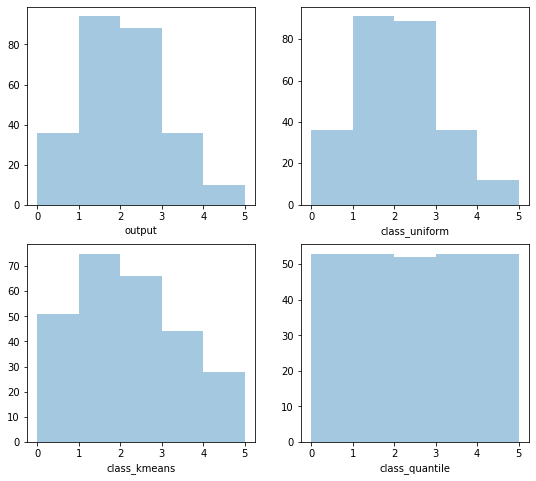

In [682]:
plt.figure(figsize=(9, 8))
plt.subplot(221)
sns.distplot(y_b["output"],bins=[0,1,2,3,4,5],hist=True,kde=False)
plt.subplot(222)
sns.distplot(y_b["class_uniform"],bins=[0,1,2,3,4,5],hist=True,kde=False)
plt.subplot(223)
sns.distplot(y_b["class_kmeans"],bins=[0,1,2,3,4,5],hist=True,kde=False)
plt.subplot(224)
sns.distplot(y_b["class_quantile"],bins=[0,1,2,3,4,5],hist=True,kde=False)
print("uniform edges" ,binner_uni.bin_edges_)
print("kmeans edges" ,binner_km.bin_edges_)
print("quantile edges" ,binner_qtl.bin_edges_)

In [683]:
y_b.head(10)

,output,class_quantile,class_kmeans,class_uniform
0,2.516485,3.0,2.0,2.0
1,1.640909,1.0,1.0,1.0
2,0.416348,0.0,0.0,0.0
3,1.338558,1.0,1.0,1.0
4,1.729517,1.0,1.0,1.0
5,2.704476,3.0,3.0,2.0
6,1.971622,2.0,2.0,1.0
7,1.843582,2.0,1.0,1.0
8,2.082107,2.0,2.0,2.0
9,2.898305,3.0,3.0,2.0


In [684]:
def make_bins(data,bin_edges):
    newList = []
    for num in data:
        i = 0;
        while i < len(bin_edges) and num >= bin_edges[i]:
            i+=1
        newNum = bin_edges[max(0,i-1)]
        newList.append(newNum)
    return newList

In [685]:
y_b.loc[:,"binned_quantile"] = make_bins(y_b["output"],binner_qtl.bin_edges_[0])
y_b.loc[:,"binned_kmeans"] = make_bins(y_b["output"],binner_km.bin_edges_[0])
y_b.loc[:,"binned_uniform"] = make_bins(y_b["output"],binner_uni.bin_edges_[0])

y_b

,output,class_quantile,class_kmeans,class_uniform,binned_quantile,binned_kmeans,binned_uniform
0,2.516485,3.0,2.0,2.0,2.300331,1.949951,1.977870
1,1.640909,1.0,1.0,1.0,1.208538,1.184543,0.994812
2,0.416348,0.0,0.0,0.0,0.011753,0.011753,0.011753
3,1.338558,1.0,1.0,1.0,1.208538,1.184543,0.994812
4,1.729517,1.0,1.0,1.0,1.208538,1.184543,0.994812
5,2.704476,3.0,3.0,2.0,2.300331,2.648525,1.977870
6,1.971622,2.0,2.0,1.0,1.788061,1.949951,0.994812
7,1.843582,2.0,1.0,1.0,1.788061,1.184543,0.994812
8,2.082107,2.0,2.0,2.0,1.788061,1.949951,1.977870
9,2.898305,3.0,3.0,2.0,2.300331,2.648525,1.977870


In [686]:
y_b = y_b.drop(labels=["class_quantile","class_kmeans","class_uniform"],axis=1)
y_b["diff_quantile"] = y_b["output"]-y_b["binned_quantile"]
y_b["diff_kmeans"] = y_b["output"]-y_b["binned_kmeans"]
y_b["diff_uniform"] = y_b["output"]-y_b["binned_uniform"]

In [687]:
y_b

,output,binned_quantile,binned_kmeans,binned_uniform,diff_quantile,diff_kmeans,diff_uniform
0,2.516485,2.300331,1.949951,1.977870,0.216155,0.566534,0.538615
1,1.640909,1.208538,1.184543,0.994812,0.432371,0.456366,0.646097
2,0.416348,0.011753,0.011753,0.011753,0.404595,0.404595,0.404595
3,1.338558,1.208538,1.184543,0.994812,0.130020,0.154015,0.343746
4,1.729517,1.208538,1.184543,0.994812,0.520979,0.544974,0.734706
5,2.704476,2.300331,2.648525,1.977870,0.404145,0.055951,0.726605
6,1.971622,1.788061,1.949951,0.994812,0.183561,0.021671,0.976810
7,1.843582,1.788061,1.184543,0.994812,0.055521,0.659039,0.848770
8,2.082107,1.788061,1.949951,1.977870,0.294046,0.132156,0.104237
9,2.898305,2.300331,2.648525,1.977870,0.597975,0.249781,0.920435


In [688]:
def find_neighbors_mean_y(X,y,X_res,n_neighbors):
    NN_obj = NearestNeighbors(n_neighbors = n_neighbors)
    NN_obj.fit(X)
    resampled_set_neighbors_list = NN_obj.kneighbors(X_res,n_neighbors)
    y_neighbors_distances = np.array(resampled_set_neighbors_list[0])
    y_neighbors = np.array([[y.loc[each_neighbor,"output"] for each_neighbor in each_data] for each_data in resampled_set_neighbors_list[1]])
    neighbors_mean_distances = np.array([np.mean(each_list) for each_list in y_neighbors_distances]).reshape(len(y_neighbors_distances),1)
    neighbors_mean_y_list = np.array([np.mean(each_list) for each_list in y_neighbors]).reshape(len(y_neighbors),1)
    return neighbors_mean_y_list, neighbors_mean_distances

mean_y, mean_dist =find_neighbors_mean_y(X,y,X,5)
y_b.loc[:,"neighbors_mean"] = mean_y
y_b.loc[:,"diff_neighbors_mean*"] = y_b["neighbors_mean"]-y_b["output"]
y_b.loc[:,"neighbors_mean_distances"] = mean_dist
a = np.array(1/(np.abs(y_b.loc[:,"diff_neighbors_mean*"])*y_b.loc[:,"neighbors_mean_distances"])).reshape(len(y_b.loc[:,"diff_neighbors_mean*"]),1)
y_b.loc[:,"neighbors_likeness_index"] = preprocessing.MinMaxScaler().fit_transform(a)

y_b.drop(columns = ["binned_quantile","binned_kmeans","binned_uniform","diff_quantile","diff_kmeans","diff_uniform"] )

,output,neighbors_mean,diff_neighbors_mean*,neighbors_mean_distances,neighbors_likeness_index
0,2.516485,2.599369,0.082884,7.591294,0.139012
1,1.640909,1.701757,0.060848,24.859739,0.056815
2,0.416348,1.910787,1.494439,25.238024,0.000623
3,1.338558,2.160018,0.821460,26.294076,0.002375
4,1.729517,2.049377,0.319860,24.340390,0.009649
5,2.704476,2.719939,0.015463,23.015278,0.247091
6,1.971622,2.537954,0.566332,24.906923,0.004553
7,1.843582,2.523708,0.680126,22.952897,0.003947
8,2.082107,2.186747,0.104639,22.311837,0.036203
9,2.898305,2.856576,-0.041729,23.101301,0.090133


In [689]:
stat_df = pd.DataFrame(columns = ["diff_quantile","diff_kmeans","diff_uniform"])
stat_df = stat_df.append(pd.Series([np.median(y_b["diff_quantile"]),np.median(y_b["diff_kmeans"]),
                          np.median(y_b["diff_uniform"]),np.median(y_b["diff_neighbors_mean*"])],
                       index=["diff_quantile","diff_kmeans","diff_uniform","diff_neighbors_mean*"],name = "median"))
stat_df = stat_df.append(pd.Series([np.var(y_b["diff_quantile"]),np.var(y_b["diff_kmeans"]),
                          np.var(y_b["diff_uniform"]),np.var(y_b["diff_neighbors_mean*"])],index=["diff_quantile","diff_kmeans","diff_uniform","diff_neighbors_mean*"],
                         name = "var"))
stat_df = stat_df.append(pd.Series([np.mean(y_b["diff_quantile"]),np.mean(y_b["diff_kmeans"]),
                          np.mean(y_b["diff_uniform"]),np.mean(y_b["diff_neighbors_mean*"])],index=["diff_quantile","diff_kmeans","diff_uniform","diff_neighbors_mean*"],
                         name = "mean"))
stat_df = stat_df.append(pd.Series([np.std(y_b["diff_quantile"]),np.std(y_b["diff_kmeans"]),
                          np.std(y_b["diff_uniform"]),np.std(y_b["diff_neighbors_mean*"])],index=["diff_quantile","diff_kmeans","diff_uniform","diff_neighbors_mean*"],
                         name = "std"))
stat_df

,diff_quantile,diff_kmeans,diff_uniform,diff_neighbors_mean*
median,0.351980,0.426716,0.533906,0.259856
var,0.134586,0.088834,0.087586,0.566238
mean,0.442396,0.454480,0.499496,0.208158
std,0.366859,0.298050,0.295949,0.752488


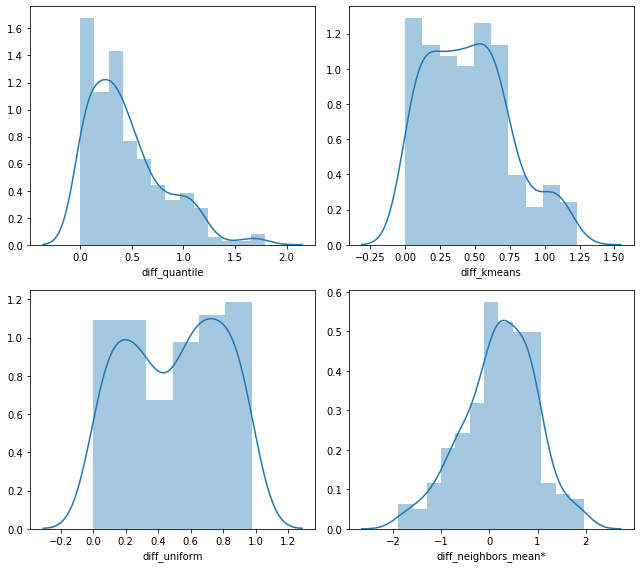

In [690]:
plt.figure(figsize=(9, 8))
plt.subplot(221)
sns.distplot(y_b["diff_quantile"],hist=True,kde=True)
plt.subplot(222)
sns.distplot(y_b["diff_kmeans"],hist=True,kde=True)
plt.subplot(223)
sns.distplot(y_b["diff_uniform"],hist=True,kde=True)
plt.subplot(224)
sns.distplot(y_b["diff_neighbors_mean*"],hist=True,kde=True)
plt.tight_layout()


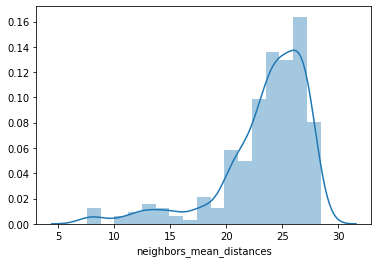

In [691]:
sns.distplot(y_b["neighbors_mean_distances"],hist=True,kde=True)


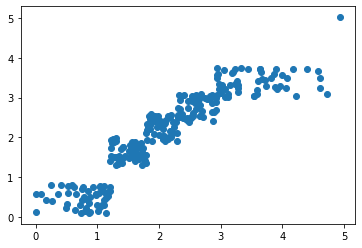

diff_quantile 0.8254926228964934


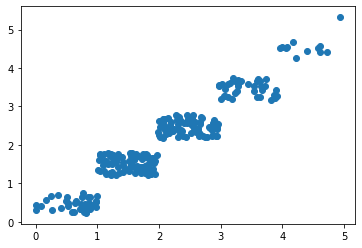

diff_uniform 0.8702456210861321


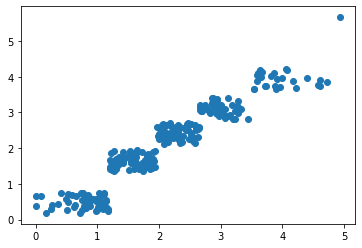

diff_kmeans 0.8763735815664814


In [692]:
for name in ["quantile","uniform","kmeans"]:
    diff = "diff_"+name
    binned_data = y_b.loc[:,"binned_"+name]
    mean = stat_df.loc["mean",diff]
    std = stat_df.loc["std",diff]
    adjusted = [each_data + (mean - std + 2*std*random()) for each_data in binned_data]
    plt.scatter(y_b["output"],adjusted,cmap=plt.get_cmap("flag"))
    plt.show()
    print(diff,r2_score(y_b["output"],adjusted))

In [693]:
y_b

,output,binned_quantile,binned_kmeans,binned_uniform,diff_quantile,diff_kmeans,diff_uniform,neighbors_mean,diff_neighbors_mean*,neighbors_mean_distances,neighbors_likeness_index
0,2.516485,2.300331,1.949951,1.977870,0.216155,0.566534,0.538615,2.599369,0.082884,7.591294,0.139012
1,1.640909,1.208538,1.184543,0.994812,0.432371,0.456366,0.646097,1.701757,0.060848,24.859739,0.056815
2,0.416348,0.011753,0.011753,0.011753,0.404595,0.404595,0.404595,1.910787,1.494439,25.238024,0.000623
3,1.338558,1.208538,1.184543,0.994812,0.130020,0.154015,0.343746,2.160018,0.821460,26.294076,0.002375
4,1.729517,1.208538,1.184543,0.994812,0.520979,0.544974,0.734706,2.049377,0.319860,24.340390,0.009649
5,2.704476,2.300331,2.648525,1.977870,0.404145,0.055951,0.726605,2.719939,0.015463,23.015278,0.247091
6,1.971622,1.788061,1.949951,0.994812,0.183561,0.021671,0.976810,2.537954,0.566332,24.906923,0.004553
7,1.843582,1.788061,1.184543,0.994812,0.055521,0.659039,0.848770,2.523708,0.680126,22.952897,0.003947
8,2.082107,1.788061,1.949951,1.977870,0.294046,0.132156,0.104237,2.186747,0.104639,22.311837,0.036203
9,2.898305,2.300331,2.648525,1.977870,0.597975,0.249781,0.920435,2.856576,-0.041729,23.101301,0.090133


In [695]:
from sklearn.linear_model import LinearRegression
np.array(y_b["output"]).reshape(264,1)
lr = LinearRegression()
lr.fit(np.array(y_b["diff_kmeans"]).reshape(len(y_b),1),np.array(y_b["neighbors_likeness_index"]).reshape(len(y_b),1)

SyntaxError: unexpected EOF while parsing (<ipython-input-695-d1b28efb7070>, line 4)

In [680]:
binning_strategy = "uniform"
X_train, X_test, y_train, y_test = train_test_split(X,y_b,stratify=y_b[binning_strategy])
X_res_km, y_res_km = sm.fit_resample(X_train,y_train[binning_strategy])
y_res_df = pd.DataFrame(y_res_km)
y_res_df.loc[:,"n_neighbor_means"] = find_neighbors_mean_y(X,y,X_res_km,n_neighbors=5)
y_res_df.loc[:,"adjusted value"] = (y_res_df[binning_strategy] + y_res_df.loc[:,"n_neighbor_means"])/2
y_res_df


In [679]:
n_neighbors_list = [1,2,3]#,4,5,6,7,8,9,10]

strategies = ["uniform", "quantile", "kmeans"]
# columns = [binning_strategy+set for set in ["_test"] for binning_strategy in strategies]
df_mean = pd.DataFrame(columns = strategies)
df = pd.DataFrame()

for n_neighbors in n_neighbors_list: 

    for binning_strategy in strategies:
        all_train_r2 = []
        all_test_r2 = []

    #   Discretizing/Binning the data
        binner = KBinsDiscretizer(n_bins=5, encode='ordinal',strategy=binning_strategy)
        y_b = y.copy()
        y_b[binning_strategy] = binner.fit_transform(np.array(y_b["output"]).reshape(264,1))

        for i in range(2):
    #       Use the binned data for stratification and for resampling
            sm = SMOTE()
            X_train, X_test, y_train, y_test = train_test_split(X,y_b,stratify=y_b[binning_strategy])
            X_res_km, y_res_km = sm.fit_resample(X_train,y_train[binning_strategy])

    #       Adjust the value after resampling
            y_res_df = pd.DataFrame(y_res_km)
                                                # Find the mean y of neighbors for all datapoints in X_res
            y_res_df.loc[:,"n_neighbor_means"] = find_neighbors_mean_y(X,y,X_res_km,n_neighbors=5)
            y_res_df.loc[:,"adjusted value"] = (y_res_df[binning_strategy] + y_res_df.loc[:,"n_neighbor_means"])/2

    #       Feed the adjusted resampled set into SVR for prediction
            svr = SVR(kernel='rbf',degree=1,gamma='scale',coef0=-50,tol=0.01,C=5,epsilon=0.1,
                      shrinking=True,cache_size=50,verbose=False)
            svr.fit(X_res_km,y_res_df["adjusted value"])      
#             y_train_pred = svr.predict(X_train)
#             all_train_r2.append(r2_score(y_train['output'],y_train_pred))
            y_test_pred = svr.predict(X_test)
            r2_test_set = r2_score(y_test['output'],y_test_pred)
            all_test_r2.append(r2_test_set)
            df = df.append(pd.Series([n_neighbors,binning_strategy,r2_test_set],index=["n_neighbors","binning_strategy","r2_test_set"],name=binning_strategy+"@"+str(n_neighbors)+"#"+str(i)),)
            
#         df.loc[n_neighbors,binning_strategy+"_train"] = np.mean(all_train_r2)
        df_mean.loc[n_neighbors,binning_strategy] = np.mean(all_test_r2)

df

In [621]:
from random import random

In [662]:
# sm = SMOTE()
# X_res_km, y_res_km = sm.fit_resample(X_train,y_train["binned_kmeans"])
# X_res_uni, y_res_uni = sm.fit_resample(X_train,y_train["binned_uniform"])
# X_res_qtl, y_res_qtl = sm.fit_resample(X_train,y_train["binned_quantile"])


In [696]:
n_neighbors = 5
neigh = NearestNeighbors(n_neighbors = n_neighbors)
neigh.fit(X)
res_neighbors_list = neigh.kneighbors(X_res_km,n_neighbors)
res_neighbors_list

(array([[ 0.        , 31.89043744, 33.91164992, 34.20526275, 34.21987726],
        [ 0.        , 10.67707825, 15.62049935, 18.27566688, 18.734994  ],
        [ 0.        , 11.3137085 , 29.22327839, 30.38091506, 30.56141358],
        ...,
        [16.64331698, 17.43559577, 19.79898987, 22.4053565 , 22.7815715 ],
        [18.16590212, 20.04993766, 20.37154879, 25.33771892, 26.05762844],
        [14.62873884, 15.        , 21.26029163, 26.41968963, 26.94438717]]),
 array([[ 79,  87,  94,  17,  88],
        [216, 228, 227, 217, 218],
        [180, 179, 181, 182, 150],
        ...,
        [148, 141, 177, 142, 150],
        [116, 138, 136, 150, 184],
        [141, 175, 142, 173, 127]], dtype=int64))

In [294]:
len(X_res_km)

270

In [295]:
y_neigh = np.array([[y.loc[neigh,"output"] for neigh in each_data] for each_data in res_neighbors_list[1]])


array([[1.35233419, 1.16652539, 2.43686697, 2.09892742, 2.0821074 ],
       [2.91946101, 3.58008861, 3.27239443, 3.86987131, 4.92704545],
       [1.13771761, 1.87067162, 1.85500149, 2.35975515, 2.19408467],
       ...,
       [3.58008861, 4.72121409, 3.04873084, 3.27239443, 3.86987131],
       [3.58836932, 3.54362293, 3.28623251, 1.24610368, 3.90466864],
       [3.95988214, 3.63239104, 1.2724603 , 1.99765188, 2.27427329]])

In [296]:
y_neighbor_mean = np.array([np.mean(ele) for ele in y_neigh]).reshape(len(y_neigh),1)

array([[1.82735228],
       [3.71377216],
       [1.88344611],
       [2.32330686],
       [1.60263108],
       [2.31415828],
       [2.18674687],
       [2.41239777],
       [2.50983752],
       [1.79926617],
       [1.08599253],
       [4.14681818],
       [2.33141665],
       [1.55739144],
       [1.95864643],
       [1.84503117],
       [2.2042219 ],
       [1.90735874],
       [2.01377699],
       [2.16791799],
       [1.8989425 ],
       [2.78848771],
       [1.73543015],
       [2.37939046],
       [2.97465424],
       [1.81099323],
       [3.02854638],
       [2.67433301],
       [2.44848783],
       [1.95351668],
       [2.99079963],
       [2.20122648],
       [2.38559637],
       [2.82698485],
       [2.01859588],
       [2.8849827 ],
       [2.52718709],
       [2.85454363],
       [2.85755394],
       [2.56911747],
       [2.80375244],
       [2.4069958 ],
       [2.11748475],
       [1.38254661],
       [3.17611213],
       [4.2814307 ],
       [2.08665585],
       [1.426

In [297]:
y_res_df["kneighbor_means"] =y_neighbor_mean
y_res_df["adjusted value"] = (y_res_df["binned_kmeans"] + y_res_df["kneighbor_means"])/2
y_res_df

,binned_kmeans,kneighbor_means,adjusted value
0,1.0,1.827352,1.413676
1,3.0,3.713772,3.356886
2,0.0,1.883446,0.941723
3,3.0,2.323307,2.661653
4,2.0,1.602631,1.801316
5,2.0,2.314158,2.157079
6,2.0,2.186747,2.093373
7,3.0,2.412398,2.706199
8,3.0,2.509838,2.754919
9,2.0,1.799266,1.899633


In [388]:
def find_neighbors_mean_y(X,y,X_res,n_neighbors):
    NN_obj = NearestNeighbors(n_neighbors = n_neighbors)
    NN_obj.fit(X)
    resampled_set_neighbors_list = NN_obj.kneighbors(X_res,n_neighbors)
    y_neighbors = np.array([[y.loc[each_neighbor,"output"] for each_neighbor in each_data] for each_data in resampled_set_neighbors_list[1]])
    neighbors_mean_y_list = np.array([np.mean(each_list) for each_list in y_neighbors]).reshape(len(y_neighbors),1)
    return neighbors_mean_y_list

strategies = ["uniform", "quantile", "kmeans"]
for binning_strategy in strategies:
    all_train_r2 = []
    all_test_r2 = []
    
#   Discretizing/Binning the data
    binner = KBinsDiscretizer(n_bins=5, encode='ordinal',strategy=binning_strategy)
    y_b = y.copy()
    y_b[binning_strategy] = binner.fit_transform(np.array(y_b["output"]).reshape(264,1))

    for i in range(50):
#       Use the binned data for stratification and for resampling
        sm = SMOTE()
        X_train, X_test, y_train, y_test = train_test_split(X,y_b,stratify=y_b[binning_strategy])
        X_res_km, y_res_km = sm.fit_resample(X_train,y_train[binning_strategy])
        
#       Adjust the value after resampling
        y_res_df = pd.DataFrame(y_res_km)
                                            # Find the mean y of neighbors for all datapoints in X_res
        y_res_df.loc[:,"kneighbor_means"] = find_neighbors_mean_y(X,y,X_res_km,n_neighbors=5)
        y_res_df.loc[:,"adjusted value"] = (y_res_df[binning_strategy] + y_res_df.loc[:,"kneighbor_means"])/2
        
#       Feed the adjusted resampled set into SVR for prediction
        svr = SVR(kernel='rbf',degree=1,gamma='scale',coef0=-50,tol=0.01,C=5,epsilon=0.1,
                  shrinking=True,cache_size=50,verbose=False)
        svr.fit(X_res_km,y_res_df["adjusted value"])      
        y_train_pred = svr.predict(X_train)
        y_test_pred = svr.predict(X_test)
        all_train_r2.append(r2_score(y_train['output'],y_train_pred))
        all_test_r2.append(r2_score(y_test['output'],y_test_pred))

    print(binning_strategy+"_train",np.mean(all_train_r2))
    print(binning_strategy+"_test",np.mean(all_test_r2))

uniform 0.7238255014150247
uniform 0.18965179378305388
quantile 0.8285610374604829
quantile 0.1833317288816719
kmeans 0.8116941350391359
kmeans 0.2196726297166239


In [446]:
n_neighbors_list = [1,2,3,4,5,6,7,8,9,10]

strategies = ["uniform", "quantile", "kmeans"]
columns = [binning_strategy+set for set in ["_test"] for binning_strategy in strategies]
df_mean = pd.DataFrame(columns = columns)
df = pd.DataFrame()

for n_neighbors in n_neighbors_list: 

    for binning_strategy in strategies:
        all_train_r2 = []
        all_test_r2 = []

    #   Discretizing/Binning the data
        binner = KBinsDiscretizer(n_bins=5, encode='ordinal',strategy=binning_strategy)
        y_b = y.copy()
        y_b[binning_strategy] = binner.fit_transform(np.array(y_b["output"]).reshape(264,1))

        for i in range(20):
    #       Use the binned data for stratification and for resampling
            sm = SMOTE()
            X_train, X_test, y_train, y_test = train_test_split(X,y_b,stratify=y_b[binning_strategy])
            X_res_km, y_res_km = sm.fit_resample(X_train,y_train[binning_strategy])

    #       Adjust the value after resampling
            y_res_df = pd.DataFrame(y_res_km)
                                                # Find the mean y of neighbors for all datapoints in X_res
            y_res_df.loc[:,"n_neighbor_means"] = find_neighbors_mean_y(X,y,X_res_km,n_neighbors=5)
            y_res_df.loc[:,"adjusted value"] = (y_res_df[binning_strategy] + y_res_df.loc[:,"n_neighbor_means"])/2

    #       Feed the adjusted resampled set into SVR for prediction
            svr = SVR(kernel='rbf',degree=1,gamma='scale',coef0=-50,tol=0.01,C=5,epsilon=0.1,
                      shrinking=True,cache_size=50,verbose=False)
            svr.fit(X_res_km,y_res_df["adjusted value"])      
#             y_train_pred = svr.predict(X_train)
#             all_train_r2.append(r2_score(y_train['output'],y_train_pred))
            y_test_pred = svr.predict(X_test)
            r2_test_set = r2_score(y_test['output'],y_test_pred)
            all_test_r2.append(r2_test_set)
            df = df.append(pd.Series([n_neighbors,binning_strategy,r2_test_set],index=["n_neighbors","binning_strategy","r2_test_set"],name=binning_strategy+"@"+str(n_neighbors)+"#"+str(i)),)
            
#         df.loc[n_neighbors,binning_strategy+"_train"] = np.mean(all_train_r2)
        df_mean.loc[n_neighbors,binning_strategy] = np.mean(all_test_r2)

df

,binning_strategy,n_neighbors,r2_test_set
uniform@1#0,uniform,1.0,0.202312
uniform@1#1,uniform,1.0,0.224544
uniform@1#2,uniform,1.0,0.212966
uniform@1#3,uniform,1.0,0.290634
uniform@1#4,uniform,1.0,0.121977
uniform@1#5,uniform,1.0,0.158887
uniform@1#6,uniform,1.0,0.191489
uniform@1#7,uniform,1.0,0.182815
uniform@1#8,uniform,1.0,0.156372
uniform@1#9,uniform,1.0,0.332632


In [445]:
df[df["binning_strategy"]=="uniform"][df["n_neighbors"]==1]
# df.filter(items=["binning_strategies","n_neighbors"])

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,binning_strategy,n_neighbors,r2_test_set
uniform@1#0,uniform,1.0,0.219222
uniform@1#1,uniform,1.0,0.127375
uniform@1#2,uniform,1.0,0.218360
uniform@1#3,uniform,1.0,0.079066
uniform@1#4,uniform,1.0,0.262583


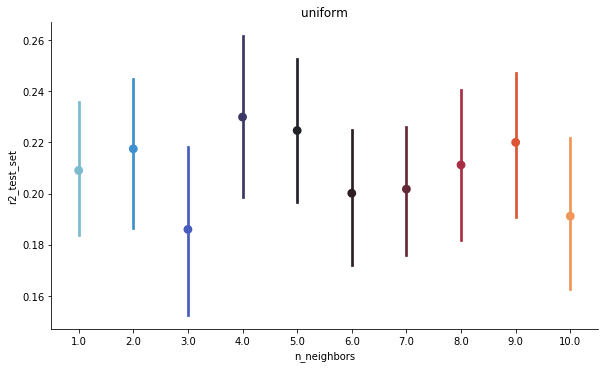

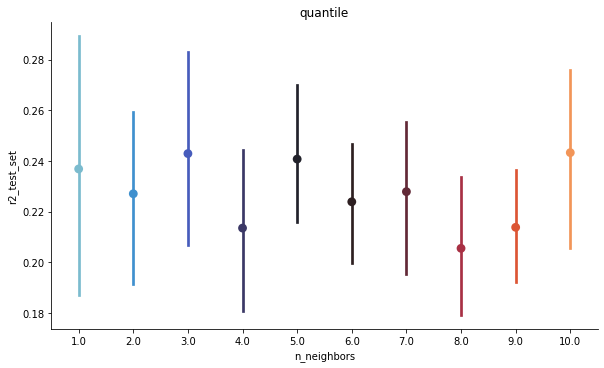

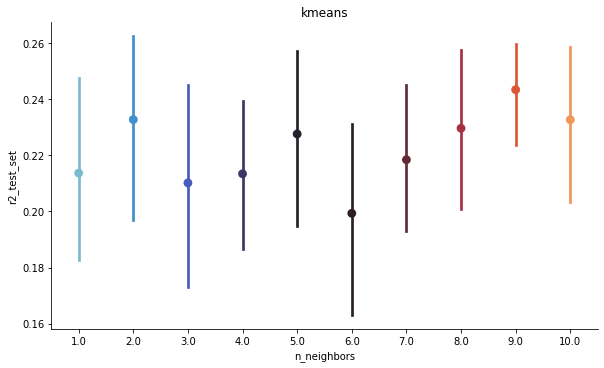

In [448]:
for col in strategies:
    sns.catplot(x="n_neighbors",y="r2_test_set",data=df[df["binning_strategy"]==col],palette="icefire",kind="point",aspect=1.7)
    plt.title(col)


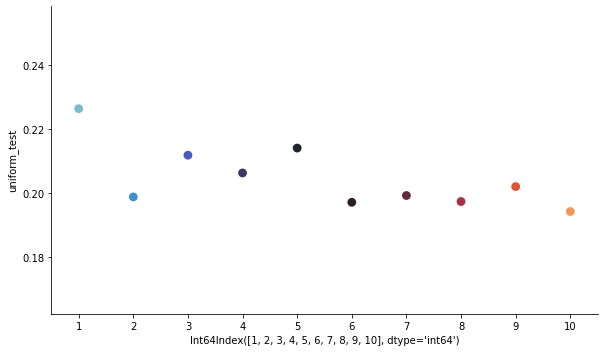

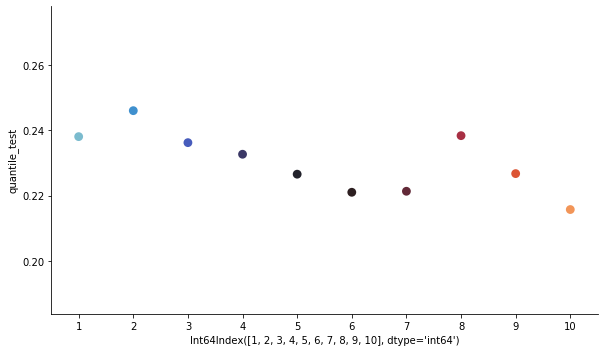

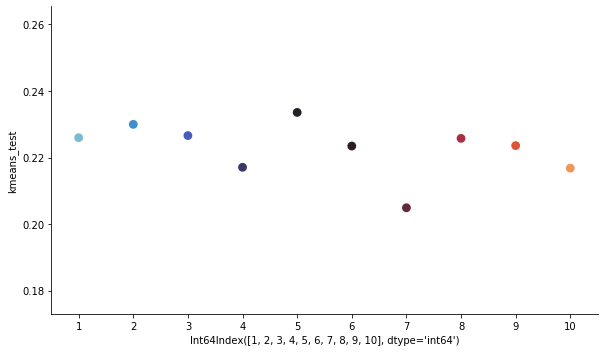

In [404]:
columns = [binning_strategy+set for set in ["_train","_test"] for binning_strategy in strategies]
for col in ["uniform_test","quantile_test","kmeans_test"]:
    sns.catplot(x=df.index,y=col,data=df,palette="icefire",kind="point",aspect=1.7)

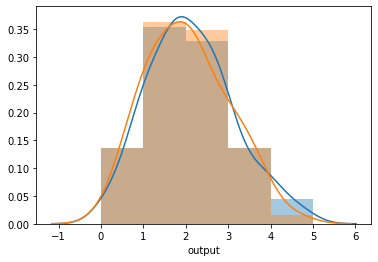

In [325]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y['binned_kmeans'])
sns.distplot(y_train["output"],bins=[0,1,2,3,4,5],hist=True,kde=True)
sns.distplot(y_test["output"],bins=[0,1,2,3,4,5],hist=True,kde=True)

In [289]:
svr.fit(X_res_km,y_res_df["adjusted value"])
y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)
print(r2_score(y_train['output'],y_train_pred))
print(r2_score(y_test['output'],y_test_pred))
y_res

0.8360978008071986
0.18824443569347338


0      3.0
1      1.0
2      1.0
3      1.0
4      1.0
5      1.0
6      0.0
7      3.0
8      3.0
9      0.0
10     3.0
11     1.0
12     0.0
13     0.0
14     1.0
15     2.0
16     1.0
17     4.0
18     2.0
19     1.0
20     2.0
21     0.0
22     3.0
23     1.0
24     2.0
25     2.0
26     2.0
27     2.0
28     0.0
29     4.0
      ... 
240    4.0
241    4.0
242    4.0
243    4.0
244    4.0
245    4.0
246    4.0
247    4.0
248    4.0
249    4.0
250    4.0
251    4.0
252    4.0
253    4.0
254    4.0
255    4.0
256    4.0
257    4.0
258    4.0
259    4.0
260    4.0
261    4.0
262    4.0
263    4.0
264    4.0
265    4.0
266    4.0
267    4.0
268    4.0
269    4.0
Name: binned_kmeans, Length: 270, dtype: float64

In [226]:
svr.fit(X_res_km,y_res_km)
y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)
y_test

,output,binned_kmeans,kmeans_diff
176,3.714335,4.0,-0.285665
180,2.511231,2.0,0.511231
98,2.179032,2.0,0.179032
36,0.252399,0.0,0.252399
230,1.520076,1.0,0.520076
138,4.721214,4.0,0.721214
49,4.050327,4.0,0.050327
20,3.959882,4.0,-0.040118
0,2.516485,2.0,0.516485
129,3.872469,4.0,-0.127531


In [136]:
print(r2_score(y_train['output'],y_train_pred))
print(r2_score(y_test['output'],y_test_pred))


0.6850542188402169
0.003556641180714637


In [233]:
def scatterplot(name,x,x_label,y,y_label,fit_reg,color):
    df1 = pd.DataFrame({x_label:x,y_label:y})
    plt.title(name)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    sns.regplot(data=df1,x=x_label,y=y_label,fit_reg=fit_reg,color=color)

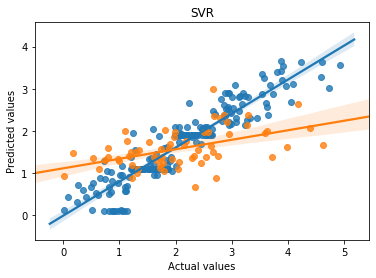

In [140]:
scatterplot("SVR", np.array(y_train['output']),"Actual values",np.array(y_train_pred).ravel(),"Predicted values",True,None)
scatterplot("SVR", np.array(y_test['output']),"Actual values",np.array(y_test_pred).ravel(),"Predicted values",True,None)


#### Distinguishing synthetic Data

In [672]:
# X_train, X_test, y_train, y_test = train_test_split(X,y_trunc)
# X_train.head()
# y_train

In [671]:
# sm = SMOTE()
# X_res,y_res = sm.fit_resample(X_train,y_train)
# X_res.head(15)
# y_res

In [261]:
print(X_train.shape, X_test.shape, X_res.shape)

(198, 1135) (66, 1135) (345, 1135)


In [262]:
df_res = X_res
df_res.loc[:,'truncated'] = y_res

df_train = X_train
df_train.loc[:,'truncated'] = y_train

df_test = X_test
df_test.loc[:,'truncated'] = y_test

# Having output has no bearing on the removal of duplicates

df_syn = df_res.append(df_train).drop_duplicates()

C:\Program Files\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Program Files\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [670]:
# df_syn
# X_syn = df_syn.iloc[:,:-1]
# y_syn = df_syn.iloc[:,-1:]

In [697]:
from sklearn.neighbors import KNeighborsRegressor

all_train_r2 = []
all_test_r2 = []

for i in range(20):
    knr = KNeighborsRegressor(n_neighbors = 5)
    X_train, X_test, y_train, y_test = train_test_split(X,y_b)
    knr.fit(X_train,y_train["output"])
    y_train_pred = knr.predict(X_train)
    y_test_pred = knr.predict(X_test)
    all_train_r2.append(r2_score(y_train['output'],y_train_pred))
    all_test_r2.append(r2_score(y_test['output'],y_test_pred))

print("train",np.mean(all_train_r2))
print("test",np.mean(all_test_r2))

train 0.34911145711685265
test -0.09552429347206262


In [265]:
clf = SVR()
X_train.iloc[:,:-1]
clf.fit(X_train.iloc[:,:-1],y_train.iloc[:,-1:])
y_train_predicted = clf.predict(X_train.iloc[:,:-1])
y_test_predicted  = clf.predict(X_test.iloc[:,:-1])
y_syn_predicted = clf.predict(X_syn)

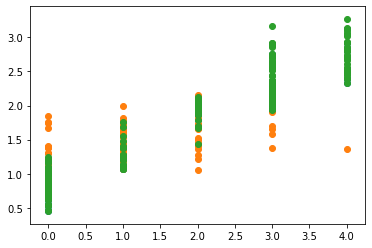

In [267]:
plt.scatter(y_train,y_train_predicted)
plt.scatter(y_test,y_test_predicted)
plt.scatter(y_syn,y_syn_predicted)

In [61]:
y_res

<function list.index(value, start=0, stop=9223372036854775807, /)>

#### make_bins() funct

In [517]:
def make_bins(data,bin_edges):
    newList = []
    for num in data:
        i = 0;
        while i < len(bin_edges) and num >= bin_edges[i]:
            i+=1
        newNum = bin_edges[max(0,i-1)]
        newList.append(newNum)
    return newList

In [14]:
from random import randint
list = [randint(1,10) for i in range(10)]
list

[1, 3, 3, 9, 10, 1, 10, 9, 10, 6]

In [15]:
bins = np.linspace(0,10,11,dtype="int")
list2 = make_bins(list,bins)

In [16]:
list2 #Nothing special yet

[1, 3, 3, 9, 10, 1, 10, 9, 10, 6]

In [17]:
bins3 = [0,1,2,7,8]
list3 = make_bins(list,bins3)
list3

[1, 2, 2, 8, 8, 1, 8, 8, 8, 2]